# MSM of Brownian dynamics simulations of diffusion on a 1D surface

 We start by importing the libraries needed for this example:

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import time
import itertools
import h5py
import numpy as np
from scipy.stats import norm
from scipy.stats import expon
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
sns.set(style="ticks", color_codes=True, font_scale=1.5)
sns.set_style({"xtick.direction": "in", "ytick.direction": "in"})

We load the trajectory data generated by Brownian Dynamics simulations.

In [3]:
h5file = "data/cossio_kl0_Dx1_Dq1.h5"
f = h5py.File(h5file, 'r')
data = np.array(f['data'])
f.close()

Text(0.5,0,u'time (ps)')

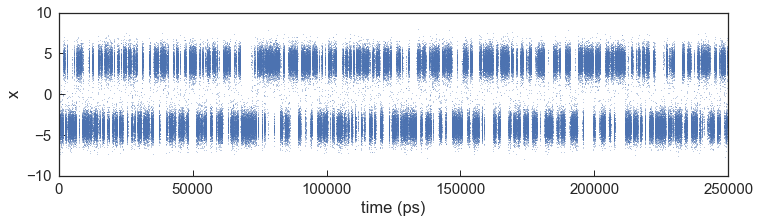

In [4]:
fig, ax = plt.subplots(figsize=(12,3))
ax.plot(data[:,0],data[:,1],'.', markersize=1)
ax.set_ylim(-10,10)
ax.set_xlim(0,250000)
ax.set_ylabel('x')
ax.set_xlabel('time (ps)')


#### Potential of Mean Force

/Users/anneaguirregonzalez/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log
  after removing the cwd from sys.path.


Text(0,0.5,u'F ($k_BT$)')

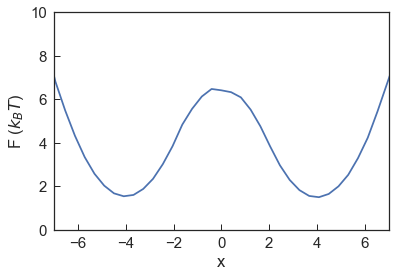

In [5]:
fig, ax = plt.subplots(figsize=(6,4))
hist, bin_edges = np.histogram(data[:,1], bins=np.linspace(-10,10,50), normed=True)
bin_centers = [0.5*(bin_edges[i]+bin_edges[i+1]) \
               for i in range(len(bin_edges)-1)]
ax.plot(bin_centers, -np.log(hist))
ax.set_xlim(-7,7)
ax.set_ylim(0,10)
ax.set_xlabel('x')
ax.set_ylabel('F ($k_BT$)')



Now we discretize the trajectory using the states obtained from making a grid on the diffusion of the molecule.

In [6]:
hist, bin_edges = np.histogram(data[:,1], bins=np.linspace(-7,7,35), normed=True)
assigned_trj=list(np.digitize(data[:,1],bins=bin_edges))

Text(0.5,0,u'time (ps)')

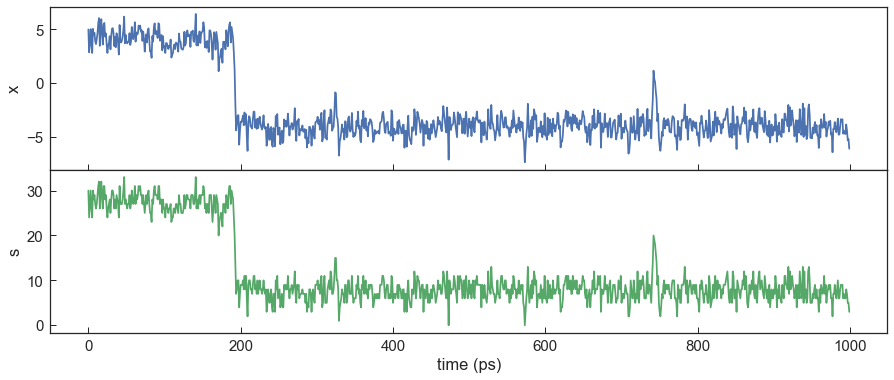

In [7]:
fig,ax=plt.subplots(2,1,figsize=(15,6))
plt.subplots_adjust(wspace=0, hspace=0)
ax[0].plot(range(0,len(data[:,1][:1000])),data[:,1][:1000])
ax[1].plot(range(0,len(assigned_trj[:1000])),assigned_trj[:1000],color="g")
ax[0].set_ylabel('x')
ax[1].set_ylabel("s")
ax[1].set_xlabel("time (ps)")

Text(0.5,0,u'time (ps)')

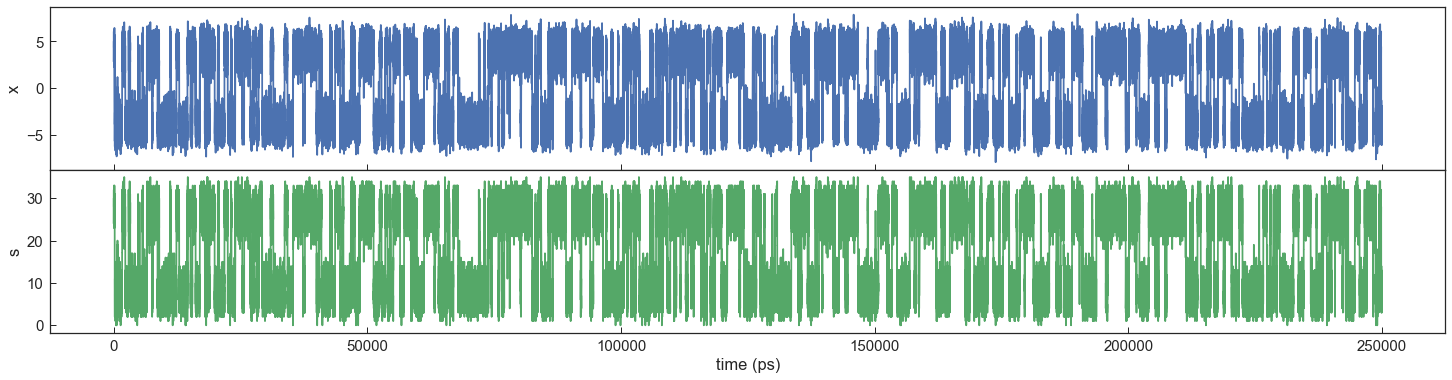

In [8]:
fig,ax=plt.subplots(2,1,figsize=(25,6))
plt.subplots_adjust(wspace=0, hspace=0)
ax[0].plot(range(0,len(data[:,1])),data[:,1])
ax[1].plot(range(0,len(assigned_trj)),assigned_trj,color="g")
ax[0].set_ylabel('x')
ax[1].set_ylabel("s")
ax[1].set_xlabel("time (ps)")

### Master Equation Model
After generating the discrete trajectory, we can build the master equation model, for which we use the msm module.


In [9]:
from mastermsm.trajectory import traj
from mastermsm.msm import msm

In [10]:
distraj=traj.TimeSeries(distraj=assigned_trj,dt=1)
distraj.find_keys()
distraj.keys.sort()


After reading the trajectory, we will create an instance of the SuperMSM class.

In [11]:
msm_1D=msm.SuperMSM([distraj])


 Building MSM from 
     # states: 36


In order to validate the model, we carry out a convergence test to check that the relaxation times $\tau$ do not show a dependency on the lag time. We build the MSM at different lag times $\Delta$t.

In [12]:
for i in [1, 2, 5, 10, 20, 50, 100]:
    msm_1D.do_msm(i, sym=False)
    msm_1D.msms[i].do_trans(evecs=True)
    msm_1D.msms[i].boots(plot=False)

/Users/anneaguirregonzalez/.local/lib/python2.7/site-packages/MasterMSM-0.1.dev0-py2.7.egg/mastermsm/msm/msm.py:715: RuntimeWarning: invalid value encountered in log
/Users/anneaguirregonzalez/.local/lib/python2.7/site-packages/MasterMSM-0.1.dev0-py2.7.egg/mastermsm/msm/msm.py:731: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/anneaguirregonzalez/.local/lib/python2.7/site-packages/MasterMSM-0.1.dev0-py2.7.egg/mastermsm/msm/msm.py:732: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/anneaguirregonzalez/.local/lib/python2.7/site-packages/MasterMSM-0.1.dev0-py2.7.egg/mastermsm/msm/msm_lib.py:526: RuntimeWarning: invalid value encountered in log
/Users/anneaguirregonzalez/.local/lib/python2.7/site-packages/MasterMSM-0.1.dev0-py2.7.egg/mastermsm/msm/msm_lib.py:526: RuntimeWarning: invalid value encountered in log
/Users/anneaguirregonzalez/.local/lib/python2.7/site-packages/MasterMSM-0.1.dev0-py2.7.egg/mastermsm/msm/msm_l

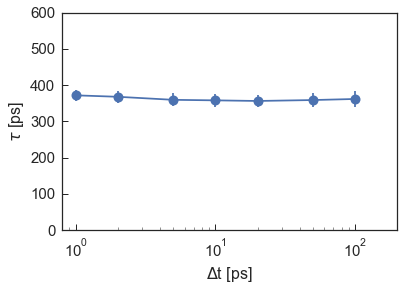

In [13]:
tau_vs_lagt = np.array([[x,msm_1D.msms[x].tauT[0],msm_1D.msms[x].tau_std[0]] \
               for x in sorted(msm_1D.msms.keys())])
fig, ax = plt.subplots()
ax.errorbar(tau_vs_lagt[:,0],tau_vs_lagt[:,1],fmt='o-', yerr=tau_vs_lagt[:,2], markersize=10)
#ax.fill_between(10**np.arange(-0.2,3,0.2), 1e-1, 10**np.arange(-0.2,3,0.2), facecolor='lightgray')
ax.set_xlabel(r'$\Delta$t [ps]', fontsize=16)
ax.set_ylabel(r'$\tau$ [ps]', fontsize=16)
ax.set_xlim(0.8,200)
ax.set_ylim(0,600)
_ = ax.set_xscale('log')

The relaxation times converge well as they are independent of the lag time.

/Users/anneaguirregonzalez/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in log
  


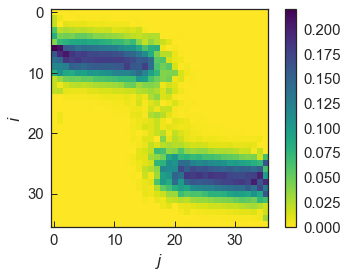

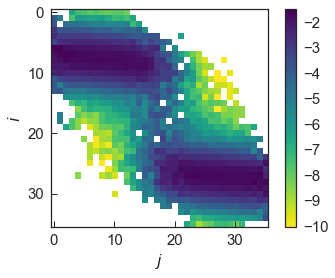

In [21]:
lt=2
plt.figure()
plt.imshow(msm_1D.msms[lt].trans, interpolation='none', \
    cmap='viridis_r')
plt.ylabel('$\it{i}$')
plt.xlabel('$\it{j}$')
plt.colorbar()
plt.figure()
plt.imshow(np.log(msm_1D.msms[lt].trans), interpolation='none', \
    cmap='viridis_r')
plt.ylabel('$\it{i}$')
plt.xlabel('$\it{j}$')
plt.colorbar()

Text(0,0.5,u'$\\tau_i$ [ns]')

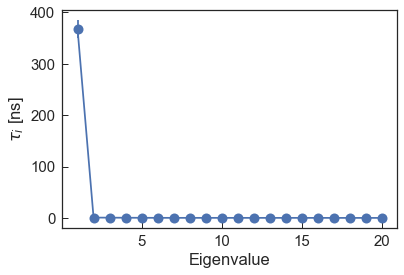

In [27]:
fig, ax = plt.subplots()
ax.errorbar(range(1,len(msm_1D.msms[lt].tauT)+1),msm_1D.msms[lt].tauT, fmt='o-', \
            yerr= msm_1D.msms[lt].tau_std, ms=10)
ax.set_xlabel('Eigenvalue')
ax.set_ylabel(r'$\tau_i$ [ns]')

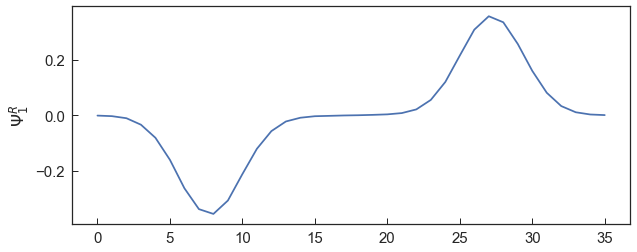

In [28]:
fig, ax = plt.subplots(figsize=(10,4))
ax.plot(msm_1D.msms[2].rvecsT[:,1])
ax.set_ylabel("$\Psi^R_1$")
plt.show()

The slowest mode in our model, captured by the first eigenvector $\Psi^R_1$, corresponds to the transition betweem the folded and unfolded states of the protein.